In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


2025-05-03 20:48:01.453871: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746305281.479928   37589 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746305281.487697   37589 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
def load_and_split_sensor_data(
    csv_path: str,
    test_size: float = 0.1,
    val_size: float = 0.2,
    random_state: int = 42
):
    """
    Load sensor CSV, preprocess (drop columns, encode labels, scale), and split into train/val/test.

    Args:
        csv_path: Path to the Gas Sensors Measurements CSV file.
        test_size: Fraction of data reserved for final test set.
        val_size: Fraction of remaining data reserved for validation.
        random_state: Random seed for reproducibility.

    Returns:
        train_ds: tf.data.Dataset for training (features, labels).
        val_ds: tf.data.Dataset for validation.
        test_ds: tf.data.Dataset for testing.
    """
    # 1) Load and clean
    df = pd.read_csv(csv_path)
    # drop unused columns
    df = df.drop(columns=["Serial Number", "Corresponding Image Name"], errors='ignore')
    # encode labels
    df['Gas'] = df['Gas'].astype('category').cat.codes

    # 2) Extract features and labels
    feature_cols = [c for c in df.columns if c != 'Gas']
    X = df[feature_cols].values.astype('float32')
    y = df['Gas'].values.astype('int32')

    # 3) Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 4) Split into train+val and test
    X_temp, X_test, y_temp, y_test = train_test_split(
        X_scaled, y, test_size=test_size, stratify=y, random_state=random_state
    )
    # Split train_temp into train and val
    val_fraction = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_fraction,
        stratify=y_temp, random_state=random_state
    )

    # 5) Build tf.data datasets
    def make_ds(features, labels, batch_size=32, shuffle=False):
        ds = tf.data.Dataset.from_tensor_slices((features, labels))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(features), seed=random_state)
        return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    batch_size = 32
    train_ds = make_ds(X_train, y_train, batch_size, shuffle=True)
    val_ds   = make_ds(X_val,   y_val,   batch_size, shuffle=False)
    test_ds  = make_ds(X_test,  y_test,  batch_size, shuffle=False)

    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = load_and_split_sensor_data("../dataset/Gas Sensors Measurements/Gas_Sensors_Measurements.csv")

2025-05-03 20:48:04.655831: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
class RandomSensorDropout(tf.keras.layers.Layer):
    def __init__(self, rate=0.3, **kwargs):
        """
        rate: probability to drop each sensor channel during training.
        **kwargs: captures `trainable`, `dtype`, etc., for deserialization.
        """
        super().__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=False):
        if training and self.rate > 0.0:
            mask = tf.cast(tf.random.uniform(tf.shape(inputs)) > self.rate, inputs.dtype)
            return inputs * mask
        return inputs

    def get_config(self):
        config = super().get_config()
        config.update({"rate": self.rate})
        return config

In [4]:
def build_sensor_model(input_dim=7,
                       sensor_dropout_rate=0.3,
                       hidden_units=[64, 32],
                       output_units=4,
                       lr=1e-4):
    inputs = tf.keras.Input(shape=(input_dim,), name="sensor_input")

    # 1) randomly drop entire channels of the raw input
    x = RandomSensorDropout(sensor_dropout_rate)(inputs)

    # 2) two hidden layers with standard Dropout
    x = tf.keras.layers.Dense(hidden_units[0], activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(hidden_units[1], activation="relu")(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    # 3) final softmax over classes
    outputs = tf.keras.layers.Dense(output_units, activation="softmax",
                                    name="output")(x)
    model = tf.keras.Model(inputs, outputs, name="sensor_only_dropout")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

Dropout=0.0 → MC Test Accuracy = 0.9594
Dropout=0.1 → MC Test Accuracy = 0.9500
Dropout=0.2 → MC Test Accuracy = 0.9406
Dropout=0.3 → MC Test Accuracy = 0.9328
Dropout=0.4 → MC Test Accuracy = 0.9281
Dropout=0.5 → MC Test Accuracy = 0.8844
Dropout=0.6 → MC Test Accuracy = 0.8719
Dropout=0.7 → MC Test Accuracy = 0.8313
Dropout=0.8 → MC Test Accuracy = 0.8047
Dropout=0.9 → MC Test Accuracy = 0.7828


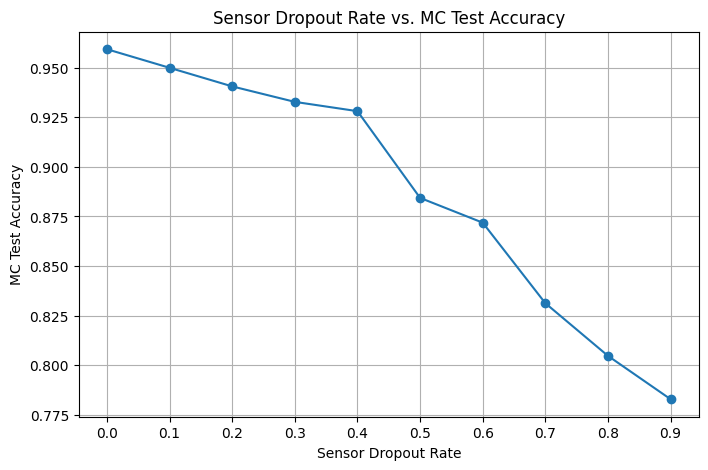

In [5]:
import matplotlib.pyplot as plt

def predict_mc(model, dataset, T=50):
    all_preds = []
    all_labels = []
    for sens_batch, lbl_batch in dataset:
        preds_t = [model(sens_batch, training=True).numpy() for _ in range(T)]
        preds_t = np.stack(preds_t, axis=0)  # (T, batch, classes)
        mean_preds = preds_t.mean(axis=0)    # (batch, classes)
        all_preds.append(mean_preds)
        all_labels.append(lbl_batch.numpy())
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    y_pred = np.argmax(all_preds, axis=1)
    return np.mean(y_pred == all_labels)

dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5 , 0.6 , 0.7 , 0.8 , 0.9]
val_accuracies = []

for rate in dropout_rates:
    model = build_sensor_model(input_dim=7, sensor_dropout_rate=rate)
    ckpt_path = f"best_sensor_dropout_{rate:.1f}.keras"
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        ckpt_path,
        monitor="val_accuracy",
        mode="max",
        save_best_only=True,
        verbose=0
    )
    model.fit(train_ds, validation_data=val_ds, epochs=100, verbose=0 , callbacks=[checkpoint_cb])
    best_model = tf.keras.models.load_model(
        ckpt_path,
        custom_objects={"RandomSensorDropout": RandomSensorDropout}
    )
    acc = predict_mc(best_model, test_ds, T=50)
    val_accuracies.append(acc)
    print(f"Dropout={rate:.1f} → MC Test Accuracy = {acc:.4f}")

# Plot dropout rate vs MC test accuracy
plt.figure(figsize=(8, 5))
plt.plot(dropout_rates, val_accuracies, marker='o')
plt.title("Sensor Dropout Rate vs. MC Test Accuracy")
plt.xlabel("Sensor Dropout Rate")
plt.ylabel("MC Test Accuracy")
plt.xticks(dropout_rates)
plt.grid(True)
plt.show()